In [1]:
# 텐서플로 2 버전 선택
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import numpy as np

* (참고) opencv, tensorflow_hub가 설치가 되어 있는지 확인!!!!

# Tensorflow_hub에 대해서 혹시 설치가 안 되어 있다면 설치하면 됨!!!!

In [2]:
# 8.1 텐서플로 허브에서 사전 훈련된 MobileNet 모델 불러오기
import tensorflow_hub as hub

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


* 전체 네트워크에 대한 구조 출력 코드

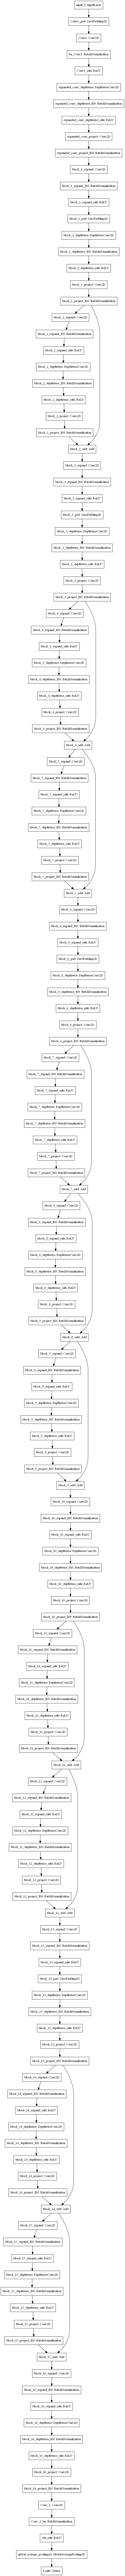

In [3]:
# 그림 8.2 좌측 전체 네트워크 구조 출력 코드
from tensorflow.keras.applications import MobileNetV2

mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

* ImageNetV2-TopImages  : 경로가 없으면 생성하고 하면 됨!!!! --> 혹시 설치 경로가 다르게 되면 다른 곳에 설치가 되고, 그러면 그 곳에 대한 경로를 확인해 주어야 함!!!!

<img src="img/img_29.png">

In [4]:
# 8.2 ImageNetV2-TopImages 불러오기
import os
import pathlib

# 기본 루트를 중심으로 아래 폴더가 없으면 생성을 하고 다운이 받아지는지 확인 필요!!!!
content_data_url = 'content/sample_data'
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz', cache_dir=content_data_url, extract=True)
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-topimages')
print(data_root)

content\sample_data\datasets\imagenetv2-topimages


In [5]:
# 디렉토리 출력!! --> 1000개 이기 때문에 중간에서 짜르기 위해서...
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

content\sample_data\datasets\imagenetv2-topimages\0
content\sample_data\datasets\imagenetv2-topimages\1
content\sample_data\datasets\imagenetv2-topimages\10
content\sample_data\datasets\imagenetv2-topimages\100
content\sample_data\datasets\imagenetv2-topimages\101
content\sample_data\datasets\imagenetv2-topimages\102
content\sample_data\datasets\imagenetv2-topimages\103
content\sample_data\datasets\imagenetv2-topimages\104
content\sample_data\datasets\imagenetv2-topimages\105
content\sample_data\datasets\imagenetv2-topimages\106


* 8.4 ImageNet 라벨 텍스트 불러오기

In [6]:
# 
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_text = None
with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


* 8.5 이미지 확인

In [7]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
# 이미지를 랜덤하게 섞습니다.
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12,12))
for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
plt.show()

image_count: 10000


IndexError: list index out of range

* 8.6 MobileNet의 분류 성능 확인 --> opencv설치 필요!!!

IndexError: list index out of range

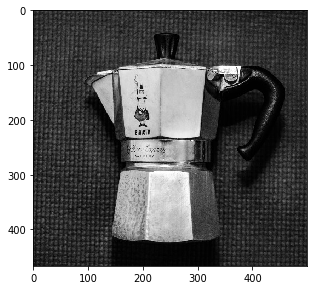

In [13]:
# 8.7 MobileNet의 분류 라벨 확인
plt.figure(figsize=(16,16))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
  
for c in range(3):
    image_path = random.choice(all_image_paths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # MobileNet을 이용한 예측
    logits = model.predict(img)[0]
    prediction = softmax(logits)
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [label_text[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])    

# Transfer Learning

## 1) 모델의 일부를 재학습 해보자!!

* 아까 받은 경로에 아래와 같아 설치를 한다.
<img src="img/img_30.png">

<img src="img/img_31.png">

In [15]:
# 8.8 Stanford Dog Dataset을 Kaggle에서 불러오기

# 2020.02.01 현재 kaggle의 Stanford Dog Dataset 파일 구조가 변경되었습니다. 
# kaggle API를 사용하는 대신에 아래 링크에서 파일을 직접 받아오도록 수정되었습니다.
# ---> 파일 경로 설정하기!!!
tf.keras.utils.get_file('/Users/1-17/Desktop/content/labels.csv', 'http://bit.ly/2GDxsYS')
tf.keras.utils.get_file('/Users/1-17/Desktop/content/sample_submission.csv', 'http://bit.ly/2GGnMNd')
tf.keras.utils.get_file('/Users/1-17/Desktop/content/train.zip', 'http://bit.ly/31nIyel')
tf.keras.utils.get_file('/Users/1-17/Desktop/content/test.zip', 'http://bit.ly/2GHEsnO')

# import os
# os.environ['KAGGLE_USERNAME'] = 'user_id' # 독자의 캐글 ID
# os.environ['KAGGLE_KEY'] = 'user_api_token' # 독자의 캐글 API Token

# !kaggle competitions download -c dog-breed-identification

362848256/362841195 [==============================] - 42s 0us/step


'C:/Users/1-17/Desktop/content/test.zip'

* 해당하는 파일들을 압출 풀기!!

위에서 바든 파일들을 직접 압축 풀기 진행~~~

* 파일 불러들이기!! --> 경로 잘 확인해서 label.csv파일 받아오기!!

In [8]:
# 8.10 labels.csv 파일 내용 확인
import pandas as pd
label_text = pd.read_csv('content/labels.csv')
print(label_text.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


*  Label정보 확인

In [9]:
label_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
id       10222 non-null object
breed    10222 non-null object
dtypes: object(2)
memory usage: 159.8+ KB


In [10]:
# 8.12 견종 수 확인
label_text['breed'].nunique()

120

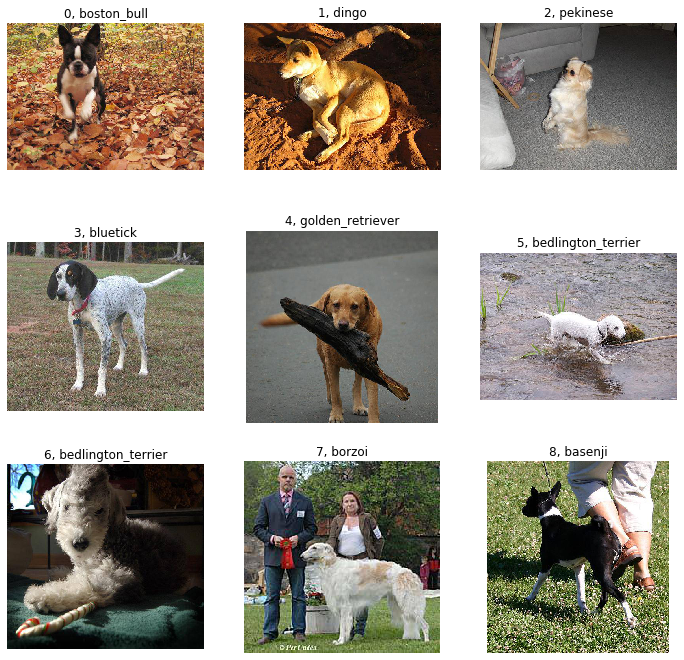

In [11]:
# 8.13 이미지 확인
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    image_id = label_text.loc[c, 'id']
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread('content/train/' + image_id + '.jpg'))
    plt.title(str(c) + ', ' + label_text.loc[c, 'breed'])
    plt.axis('off')
plt.show()

In [12]:
# 8.14 tf.keras에서 MobileNet V2 불러오기
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

* 불러온 모델의 가중치 초기화!!!

In [15]:
# 8.15 MobileNet V2의 가중치 초기화
for layer in mobilev2.layers[:-1]:
    layer.trainable = True
    
for layer in mobilev2.layers[:-1]: 
    if 'kernel' in layer.__dict__:
        kernel_shape = np.array(layer.get_weights()).shape
        # weight를 평균이 0, 표준편차가 1인 random 변수로 초기화
        layer.set_weights(tf.random.normal(kernel_shape, 0, 1))        

* train 데이터 불러오기

In [16]:
# 8.16 train 데이터를 메모리에 로드
import cv2

train_X = []
for i in range(len(label_text)):
    img = cv2.imread('content/train/' + label_text['id'][i] + '.jpg')
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    train_X.append(img)
train_X = np.array(train_X)
print(train_X.shape)
print(train_X.size * train_X.itemsize, ' bytes')

ModuleNotFoundError: No module named 'cv2'

In [17]:
# 8.17 train 라벨 데이터를 메모리에 로드
unique_Y = label_text['breed'].unique().tolist()
train_Y = [unique_Y.index(breed) for breed in label_text['breed']]
train_Y = np.array(train_Y)

print(train_Y[:10])
print(train_Y[-10:])

[0 1 2 3 4 5 5 6 7 8]
[34 87 91 63 48  6 93 63 77 92]
